In [9]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
import os

In [10]:
# define folder where your data is stored
directory = 'C:/D_disk/02_Learning/27_Ughent_courses/32_Master_dissertation/Melika_Git/Data'

# get all files in directory
all_files = os.listdir(directory)
all_files

['film_links_by_genre.csv',
 'README.md',
 'reviews_4000.csv',
 'usernames.csv',
 'usernames_2.csv',
 'usernames_3.csv',
 'usernames_action.csv']

In [11]:
# read files
film = pd.read_csv('C:/D_disk/02_Learning/27_Ughent_courses/32_Master_dissertation/Melika_Git/Data/film_links_by_genre.csv')
reviews = pd.read_csv('C:/D_disk/02_Learning/27_Ughent_courses/32_Master_dissertation/Melika_Git/Data/reviews_4000.csv')

In [12]:
# clean reviews

# check reviews null value
print(reviews.isnull().sum())

# show
reviews.head(5)

user_id     0
film        0
comment    79
date        0
rating      0
dtype: int64


,user_id,film,comment,date,rating
0,/film_addiction/,quills,Watched this trash only because Joaquin Phoeni...,03 Sep 2024,★
1,/film_addiction/,children-of-divorce,This was the first Gary Coopers movie that I w...,25 Aug 2024,★★★★★
2,/film_addiction/,morocco,Spoilers !A classic without a doubt. Dietrich ...,25 Aug 2024,★★★
3,/film_addiction/,design-for-living,Absolutely loved this movie ! The humor and th...,25 Aug 2024,★★★★★
4,/dustymoth/,jfk,It was so long that I stopped caring who kille...,22 Oct 2024,★★


In [13]:
# Transfer reviews date time
# Check for out-of-bounds dates
invalid_dates = reviews[~reviews['date'].str.match(r'^\d{2} \w{3} \d{4}$')]

# Attempt to convert the 'date' column to datetime, while handling errors
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')

# Check for rows with NaT (Not a Time) which indicates failed conversions
invalid_date_rows = reviews[reviews['date'].isna()]

# Optionally, drop or fill NaT values
reviews = reviews.dropna(subset=['date']) 


In [14]:
# Transfer the rating
# Define a function to convert star ratings to numerical values
def convert_rating(rating):
    # Remove any fractions from the ratings
    if '½' in rating:
        return (rating.count('★') + 0.5)  # Count stars and add 0.5 for half star
    return rating.count('★')  # Count stars

# Apply the conversion function to the 'rating' column
reviews['rating'] = reviews['rating'].apply(convert_rating)

In [15]:
reviews['rating'].value_counts()

rating
4.0    72297
3.0    54798
3.5    54568
5.0    50596
4.5    32442
0.0    29921
2.5    26416
2.0    23236
1.0    10208
1.5     9846
0.5     6175
Name: count, dtype: int64

In [16]:
# Cleaning the userid
reviews['user_id']=reviews['user_id'].str.replace('/','')

In [17]:
# Get unique user_id and film
user_film = reviews[['user_id','film']].drop_duplicates()

# Get the unique films and unique users
print('Unique users: ',len(user_film['user_id'].unique()))
print('Unique films: ',len(user_film['film'].unique()))

Unique users:  3747
Unique films:  61233


In [18]:
# Check the film number per user
film_per_user = user_film.groupby('user_id')['film'].count().reset_index()
film_per_user = film_per_user.rename(columns={'film':'Count'})
print('The max number film per user:', film_per_user['Count'].max())
print('The min number film per user:', film_per_user['Count'].min())
print('The average number film per user:', film_per_user['Count'].mean())
print('The median number film per user:', film_per_user['Count'].median())
print('The 25 percent number film per user:', film_per_user['Count'].quantile(0.25))
print('The 75 percent number film per user:', film_per_user['Count'].quantile(0.75))

The max number film per user: 156
The min number film per user: 1
The average number film per user: 91.8070456365092
The median number film per user: 115.0
The 25 percent number film per user: 65.0
The 75 percent number film per user: 120.0


{'whiskers': [<matplotlib.lines.Line2D at 0x2e508dba370>,
 'caps': [<matplotlib.lines.Line2D at 0x2e508dba8b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e508dba1f0>],
 'medians': [<matplotlib.lines.Line2D at 0x2e508dbadf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e508dcf0d0>],
 'means': []}

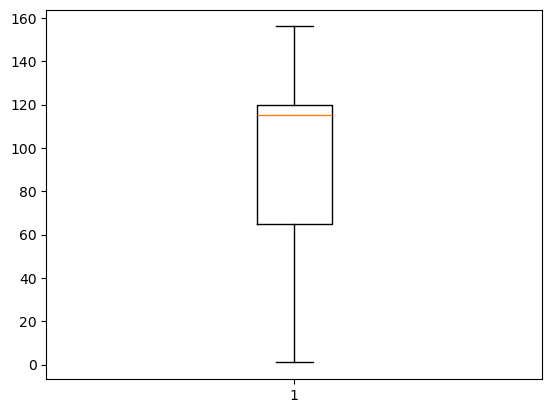

In [19]:
plt.boxplot(film_per_user['Count'])

Contamination: 0.1, Number of detected outliers: 367


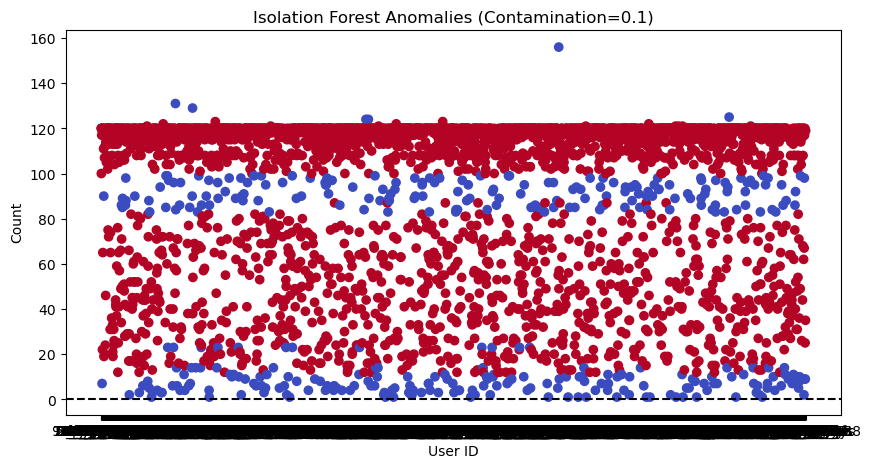

Contamination: 0.2, Number of detected outliers: 737


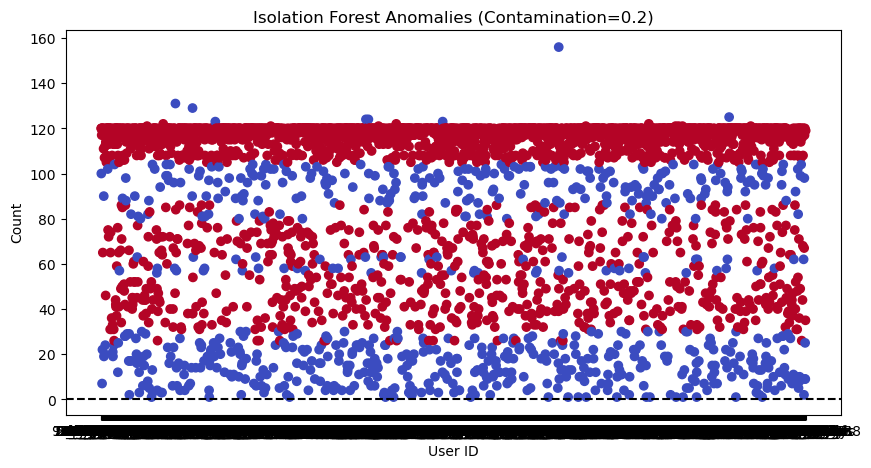

Contamination: 0.3, Number of detected outliers: 1117


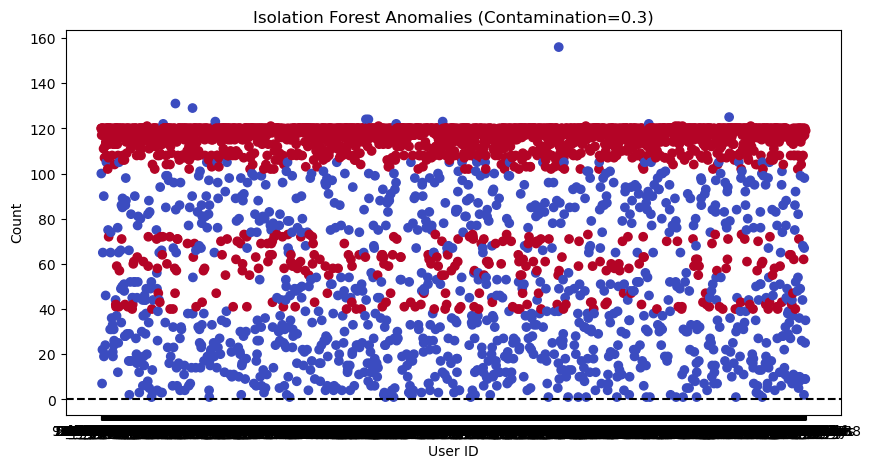

Contamination: 0.4, Number of detected outliers: 1479


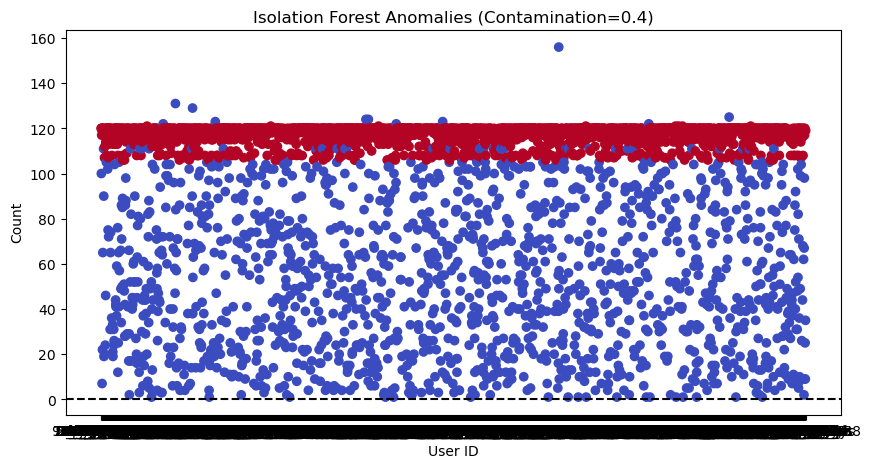

Contamination: 0.5, Number of detected outliers: 1851


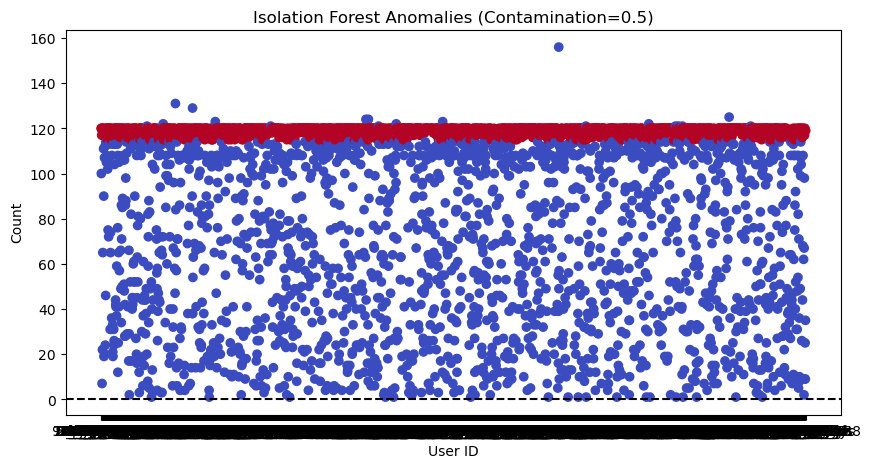

In [20]:
# Use insolation Forest to test outliers
contamination_levels = [0.1, 0.2,0.3,0.4,0.5]  

for contamination in contamination_levels:
    model = IsolationForest(contamination=contamination)
    film_per_user['anomaly'] = model.fit_predict(film_per_user[['Count']])
    
    # Step 3: Evaluate the results
    num_outliers = (film_per_user['anomaly'] == -1).sum()
    print(f"Contamination: {contamination}, Number of detected outliers: {num_outliers}")
    
    # Optional: Visualize anomalies
    plt.figure(figsize=(10, 5))
    plt.scatter(film_per_user['user_id'], film_per_user['Count'], c=film_per_user['anomaly'], cmap='coolwarm')
    plt.title(f'Isolation Forest Anomalies (Contamination={contamination})')
    plt.xlabel('User ID')
    plt.ylabel('Count')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.show()

Points labeled as 1 (inliers) usually appear in one color (e.g., blue).
Points labeled as -1 (outliers) will be in another color (e.g., red).

In [21]:
# Detect outliers
# Fit the model
model = IsolationForest(contamination=0.4)  # Adjust contamination based on expected outlier ratio
film_per_user['anomaly'] = model.fit_predict(film_per_user[['Count']])

# Identify outliers
outliers_user = film_per_user[film_per_user['anomaly'] == -1]
outliers_user = outliers_user.reset_index()[['user_id','Count']]
outliers_user.sort_values(by='Count')

,user_id,Count
226,carolmfranco,1
585,isbreadstick,1
1146,robinlange,1
1304,thesweeper1,1
946,mourangotango,1
...,...,...
538,hotsake,124
1295,thecjgh,125
188,brthrash,129
158,benschade,131


In [22]:
# Filter outliters from film_per_user
merged = film_per_user.merge(outliers_user, on=['user_id', 'Count'], how='left', indicator=True)
filtered_user_IF = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')

{'whiskers': [<matplotlib.lines.Line2D at 0x2e515494d60>,
 'caps': [<matplotlib.lines.Line2D at 0x2e518f67130>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e515494ac0>],
 'medians': [<matplotlib.lines.Line2D at 0x2e518f675b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e518e64670>],
 'means': []}

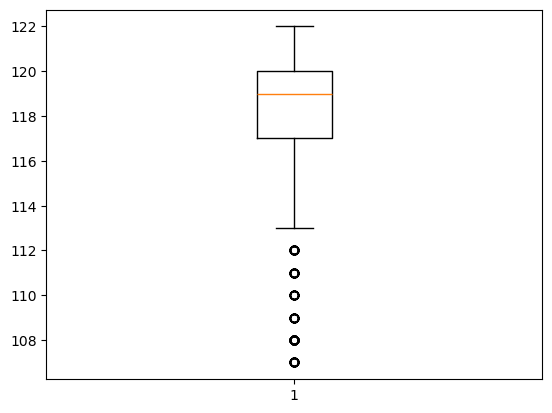

In [23]:
plt.boxplot(filtered_user_IF['Count'])

In [24]:
# Check the user number per film
user_per_film = user_film.groupby('film')['user_id'].count().reset_index()
user_per_film = user_per_film.rename(columns={'user_id':'Count'})
print('The max number user per film:', user_per_film['Count'].max())
print('The min number user per film:', user_per_film['Count'].min())
print('The average number user per film:', user_per_film['Count'].mean())
print('The median number user per film:', user_per_film['Count'].median())
print('The 25 percent number user per film:', user_per_film['Count'].quantile(0.25))

The max number user per film: 1048
The min number user per film: 1
The average number user per film: 5.617902111606487
The median number user per film: 1.0
The 25 percent number user per film: 1.0


{'whiskers': [<matplotlib.lines.Line2D at 0x2e50c8b5d90>,
 'caps': [<matplotlib.lines.Line2D at 0x2e50c8a1580>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e50c8b5850>],
 'medians': [<matplotlib.lines.Line2D at 0x2e50c8a1310>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e50c8a1850>],
 'means': []}

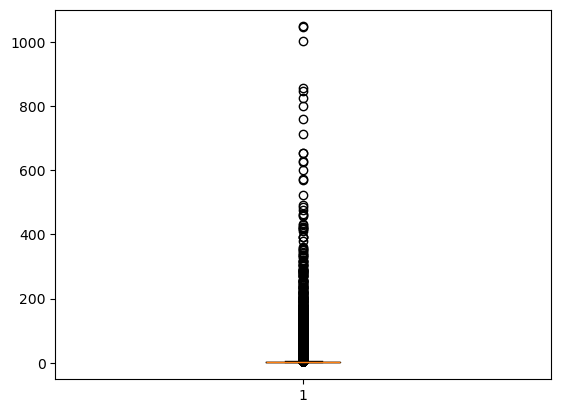

In [25]:
plt.boxplot(user_per_film['Count'])

Contamination: 0.1, Number of detected outliers: 5627


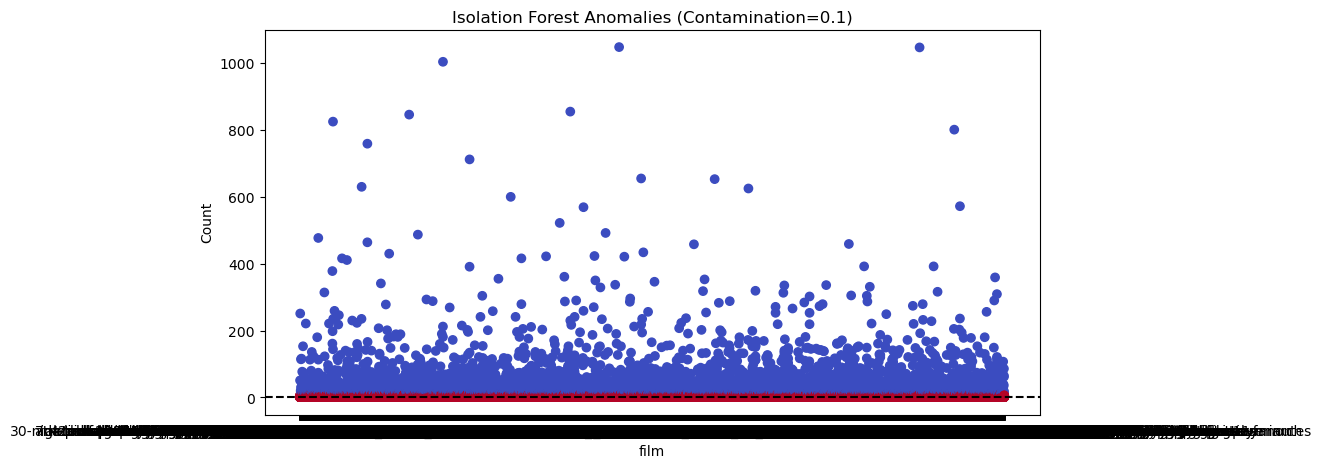

Contamination: 0.2, Number of detected outliers: 11397


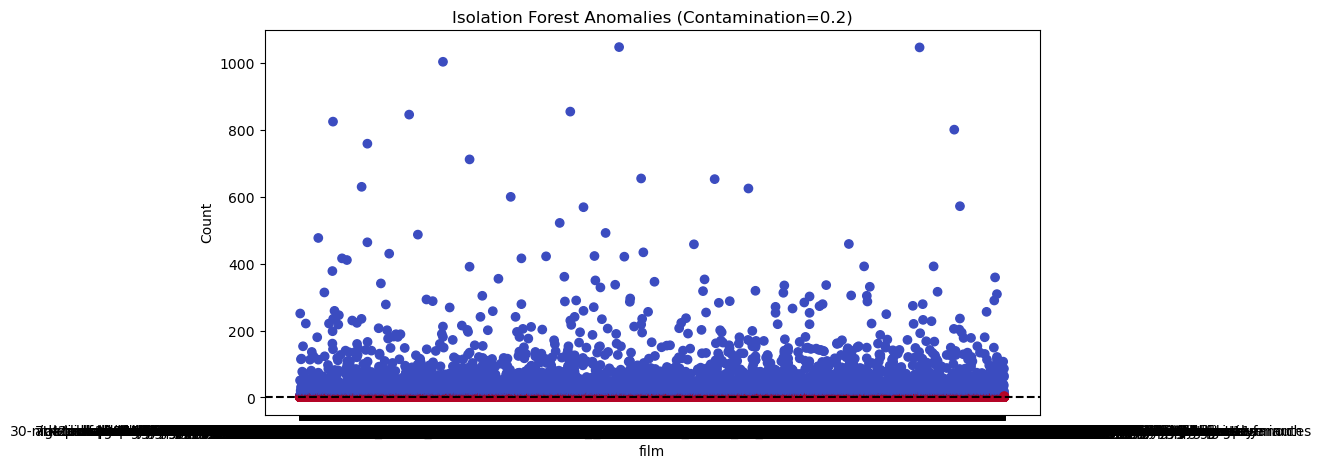

Contamination: 0.3, Number of detected outliers: 18078


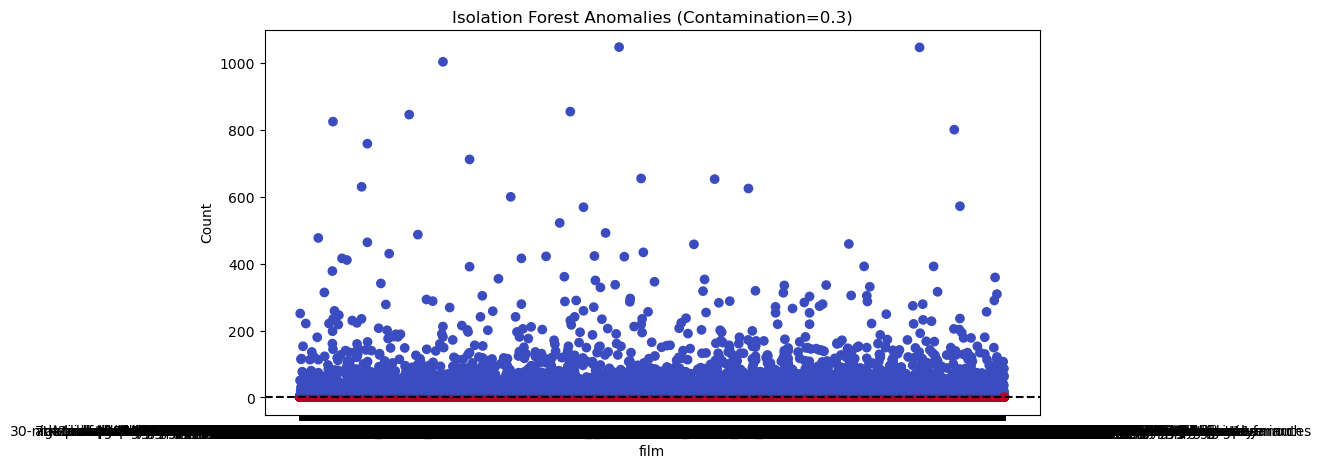

Contamination: 0.4, Number of detected outliers: 18078


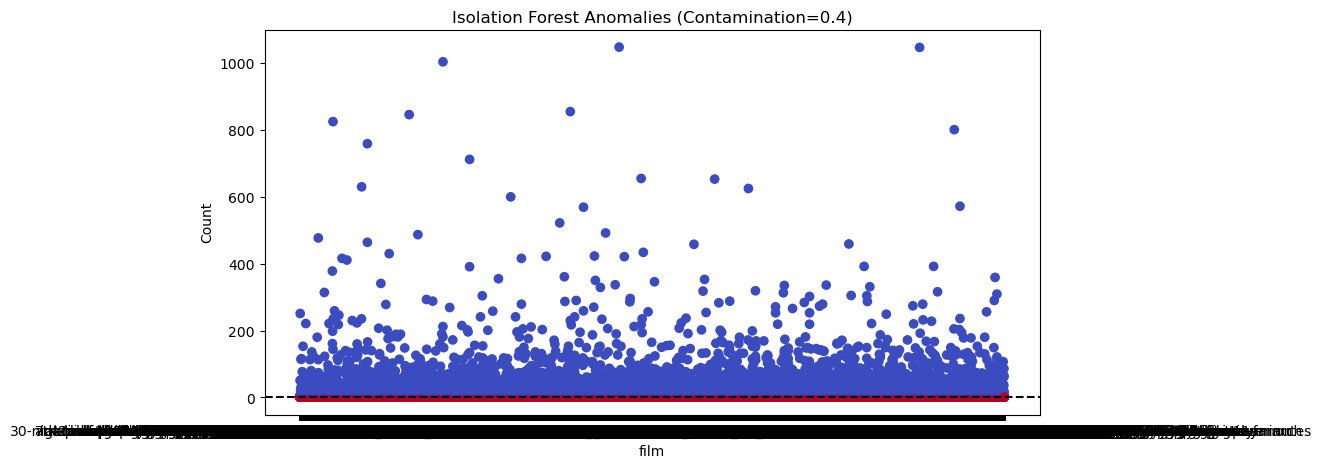

Contamination: 0.5, Number of detected outliers: 27080


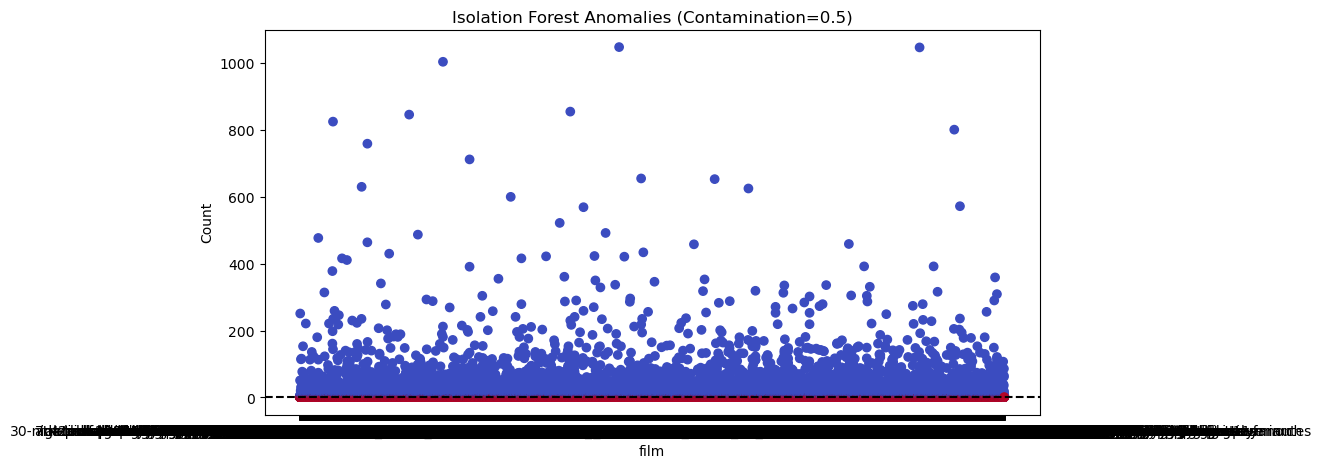

In [26]:
# Use insolation Forest to test outliers
contamination_levels = [0.1, 0.2,0.3,0.4,0.5]  

for contamination in contamination_levels:
    model = IsolationForest(contamination=contamination)
    user_per_film['anomaly'] = model.fit_predict(user_per_film[['Count']])
    
    # Step 3: Evaluate the results
    num_outliers = (user_per_film['anomaly'] == -1).sum()
    print(f"Contamination: {contamination}, Number of detected outliers: {num_outliers}")
    
    # Optional: Visualize anomalies
    plt.figure(figsize=(10, 5))
    plt.scatter(user_per_film['film'], user_per_film['Count'], c=user_per_film['anomaly'], cmap='coolwarm')
    plt.title(f'Isolation Forest Anomalies (Contamination={contamination})')
    plt.xlabel('film')
    plt.ylabel('Count')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.show()

In [27]:
# Detect outliers
# Fit the model
model = IsolationForest(contamination=0.5)  # Adjust contamination based on expected outlier ratio
user_per_film['anomaly'] = model.fit_predict(user_per_film[['Count']])

# Identify outliers
outliers_film = user_per_film[user_per_film['anomaly'] == -1]
outliers_film = outliers_film.reset_index()[['film','Count']]
outliers_film.sort_values(by='Count')

,film,Count
7183,faraway-2023,2
8497,gone-with-the-bullets,2
19739,the-batman-superman-movie-worlds-finest,2
19738,the-batman-part-ii,2
8500,gonin,2
...,...,...
4081,challengers,846
10318,inside-out-2-2024,855
5370,deadpool-wolverine,1004
23850,the-substance,1047


In [28]:
# Filter outliters from film_per_user
merged = user_per_film.merge(outliers_film, on=['film', 'Count'], how='left', indicator=True)
filtered_film_IF = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')

{'whiskers': [<matplotlib.lines.Line2D at 0x2e5426b42e0>,
 'caps': [<matplotlib.lines.Line2D at 0x2e5426b4850>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e5426d4fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x2e5426b4d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e5426d60a0>],
 'means': []}

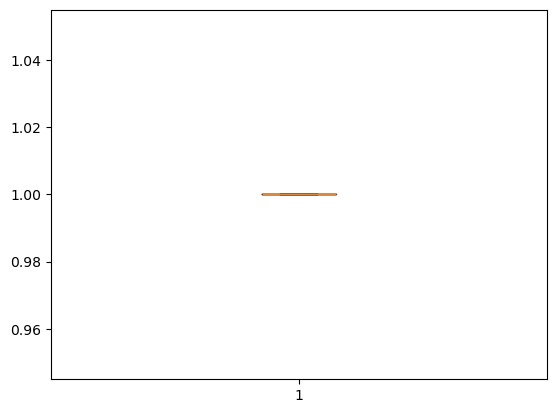

In [29]:
plt.boxplot(filtered_film_IF['Count'])

In [30]:
# Filter the number of user
filtered_user1 = film_per_user[film_per_user['Count']>=film_per_user['Count'].mean()]
filtered_user2 = filtered_user_IF

# Filter the number of film is less than 5
filtered_film1 = user_per_film[user_per_film['Count']>=user_per_film['Count'].mean()]
filtered_film2 = filtered_film_IF

print('original user:',film_per_user.shape[0],'filtered users by average:',filtered_user1.shape[0],'filtered users by IsolationForest:',filtered_user2.shape[0])
print('original user:',user_per_film.shape[0],'filtered users by average:',filtered_film1.shape[0],'filtered users by IsolationForest:',filtered_film2.shape[0])

original user: 3747 filtered users by average: 2498 filtered users by IsolationForest: 2280
original user: 61233 filtered users by average: 9638 filtered users by IsolationForest: 34153


In [36]:
# Define a funtion to calcualte the matrix 

def filtered_user_film_matrix(filtered_user,filtered_film):

    # merge the final table user-film-rating
    final_filtered_df = filtered_user.merge(reviews,how='left',on='user_id').merge(filtered_film,how='inner',on='film')
    final_filtered_df=final_filtered_df[['user_id','film','rating']]
    final_filtered_df = final_filtered_df.drop_duplicates()

    # Initialize separate LabelEncoders for user_id and Film
    user_encoder = LabelEncoder()
    film_encoder = LabelEncoder()

    # Encode the 'user_id' column
    final_filtered_df['user_id'] = user_encoder.fit_transform(final_filtered_df['user_id'])

    # Encode the 'Film' column
    final_filtered_df['film'] = film_encoder.fit_transform(final_filtered_df['film'])

    # Create user-item matrix
    user_item_matrix = final_filtered_df.pivot_table(index='user_id', columns='film', values='rating', fill_value=0)

    # Calculate sparsity
    num_non_zero_entries = (user_item_matrix != 0).sum().sum()  # Count of non-zero entries
    total_entries = user_item_matrix.size  # Total entries in the matrix
    sparsity = 1 - (num_non_zero_entries / total_entries)  # Sparsity value
    sparsity_percentage = sparsity * 100  # Sparsity percentage

    print(f'Martix size:',final_filtered_df.shape)
    print(f"Sparsity: {sparsity:.4f}")
    print(f"Sparsity Percentage: {sparsity_percentage:.2f}%")
    return user_item_matrix
    

In [37]:
# Check sparsity
df_avg = filtered_user_film_matrix(filtered_user1,filtered_film1)

Martix size: (215470, 3)
Sparsity: 0.9917
Sparsity Percentage: 99.17%


In [38]:
# Check sparsity
df_IF = filtered_user_film_matrix(filtered_user2,filtered_film2)

Martix size: (29679, 3)
Sparsity: 0.9996
Sparsity Percentage: 99.96%


Summary: 
- --> Both methods(1. fliter users and film by averge threshold and 2. isolation forest) have high sparsity (>99.9%)
- --> In next step, we will clustering the films first. Use the clasters as film to construct the user-item matrix.

In [39]:
df_avg

film,0,1,2,3,4,5,6,7,8,9,...,9628,9629,9630,9631,9632,9633,9634,9635,9636,9637
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Calculate sparsity for each user
sparsity_per_user = (df_avg == 0).mean(axis=1)  # Mean of zero entries per user

# Set sparsity threshold
sparsity_threshold = 0.99

# Filter users below the sparsity threshold
users_to_keep = sparsity_per_user[sparsity_per_user <= sparsity_threshold].index

# Create a new user-item matrix with filtered users
filtered_user_item_matrix = df_avg.loc[users_to_keep]

print(filtered_user_item_matrix)

film     0     1     2     3     4     5     6     7     8     9     ...  \
user_id                                                              ...   
0         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
8         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
11        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2471      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2473      0.0   0.0   2.5   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2489      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2490      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2492      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

film     96